# <b>AGN Percentages<b>

The contents of this notebook were originally created by Thomas Kennedy.
Minor updates have been added by Midori Rollins and Melissa Graham.
    
The ultimate goal of this notebook is to find what percentages of our AGN candidates have matches with known AGN in various other catalogues.

*(Up to 2023A data)*

---

## Set-Up

For passwords and database access, and other necessary pacakges.

In [1]:
import psycopg2
import psycopg2.extras
import getpass
import matplotlib.pyplot as plt
from astropy.coordinates import SkyCoord
import astropy.units as u
import numpy as np
import shapely.wkt as wkt
from shapely.geometry import Point

The `db.autocommit = True` statement makes the computer nicer about SQL syntax errors

In [2]:
dbuser = input("DB User: ")
dbpasswd = getpass.getpass("DB Password: ")
db = psycopg2.connect(f"dbname='decat' user='{dbuser}' password='{dbpasswd}' host='decatdb.lbl.gov'")

db.autocommit = True

cursor = db.cursor(cursor_factory = psycopg2.extras.DictCursor)

DB User:  midorr
DB Password:  ········


As Rob has said, things in the database are tagged with versions.
Everything that's in the database should be tagged with the "latest" tag (for now).
Eventually we'll probably want to use "default".

In [3]:
tag = "latest"
db.rollback()
q = ("SELECT id,tag FROM versiontags WHERE tag=%(tag)s")
cursor.execute(q, {"tag": tag})
row = cursor.fetchone()
tagid = row['id']

## Retrive the RA and Dec of a bunch of objects in COSMOS and ELAIS

Recall that "objects" are detections in a difference image.
These objects are used to define the field boundaries.
A real/bogus score > 0.6 is required, and association with one of the 4 semesters of the DDF program.

Note that the `LIMIT 10000000` ended up being unnecessary, as <500000 objects are returned as of Dec 2022.

First for COSMOS.

In [6]:
%%time
query_cosmos = ("SELECT od.ra, od.dec "
                "FROM objectdatas AS od "
                "INNER JOIN objectdata_versiontag AS odvt ON od.id=odvt.objectdata_id AND odvt.versiontag_id=%(tagid)s "
                "INNER JOIN objects AS o ON od.object_id=o.id "
                "INNER JOIN images AS i ON o.image_id=i.id "
                "INNER JOIN objectrbs as rbs ON od.id=rbs.objectdata_id AND rbs.rbtype_id=2 "
                "INNER JOIN exposures AS e ON i.exposure_id=e.id "
                "WHERE od.ra > 147.0 AND od.ra < 154.0 AND od.dec > 0 "  # isolating COSMOS field
                "AND rbs.rb > 0.6 "
                "AND (e.proposalid = '2021A-0113' OR e.proposalid = '2021B-0149' OR "
                "e.proposalid = '2022A-724693' OR e.proposalid = '2022B-762878' OR "
                "e.proposalid = '2023A-716082') "
                "LIMIT 10000000")

cursor.execute(query_cosmos, {'tagid': tagid})
radecquery_cosmos = np.array(cursor.fetchall()).T
radecquery_cosmos = np.unique(radecquery_cosmos.T, axis=0).T

CPU times: user 3.64 s, sys: 188 ms, total: 3.83 s
Wall time: 10.5 s


Now for ELAIS.

In [5]:
%%time
query_elais = ("SELECT od.ra, od.dec "
               "FROM objectdatas AS od "
               "INNER JOIN objectdata_versiontag AS odvt ON od.id=odvt.objectdata_id AND odvt.versiontag_id=%(tagid)s "
               "INNER JOIN objects AS o ON od.object_id=o.id "
               "INNER JOIN images AS i ON o.image_id=i.id "
               "INNER JOIN objectrbs as rbs ON od.id=rbs.objectdata_id AND rbs.rbtype_id=2 "
               "INNER JOIN exposures AS e ON i.exposure_id=e.id "
               "WHERE od.ra > 5.0 AND od.ra < 12.0 AND od.dec > -46 AND od.dec < -41 "  # isolating ELAIS field
               "AND rbs.rb > 0.6 " 
               "AND (e.proposalid = '2021A-0113' OR e.proposalid = '2021B-0149' OR "
               "e.proposalid = '2022A-724693' OR e.proposalid = '2022B-762878' OR "
               "e.proposalid = '2023A-716082') "
               "LIMIT 10000000")

cursor.execute(query_elais, {'tagid': tagid})
radecquery_elais = np.array(cursor.fetchall()).T
radecquery_elais = np.unique(radecquery_elais.T, axis=0).T

CPU times: user 867 ms, sys: 26.7 ms, total: 894 ms
Wall time: 4.44 s


Print the number of objects retrieved for COSMOS and ELAIS.

In [7]:
print(len(radecquery_cosmos[0,:]), len(radecquery_elais[0,:]))

498153 109682


## Make simple polygons enclosing our fields

"Simple" means short enough that its vertices fit in an ADQL query.

First, create polygon objects using all of the points as vertices, for COSMOS and ELAIS.

In [8]:
polystr_cosmos = str([str(i[0])+" "+str(i[1]) for i in np.round(radecquery_cosmos.T,2)]).replace("'","")
pol_cosmos = wkt.loads("POLYGON (({}))".format(polystr_cosmos[1:-1]+', '+polystr_cosmos[1:12]))

In [9]:
pol_cosmos

In [10]:
polystr_elais = str([str(i[0])+" "+str(i[1]) for i in np.round(radecquery_elais.T,2)]).replace("'","")
pol_elais = wkt.loads("POLYGON (({}))".format(polystr_elais[1:-1]+', '+polystr_elais[1:12]))

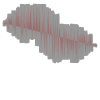

In [11]:
pol_elais

Simplify the polygons to the simplest convex shape that encloses all data.

Then plot COSMOS/ELAIS data (blue), and the simplest convex polygons enclosing all points for each field (orange lines).

In [12]:
polconvhull_cosmos = pol_cosmos.convex_hull
polconvhull_elais = pol_elais.convex_hull
convhullarr_cosmos = polconvhull_cosmos.exterior.coords.xy
convhullarr_elais = polconvhull_elais.exterior.coords.xy

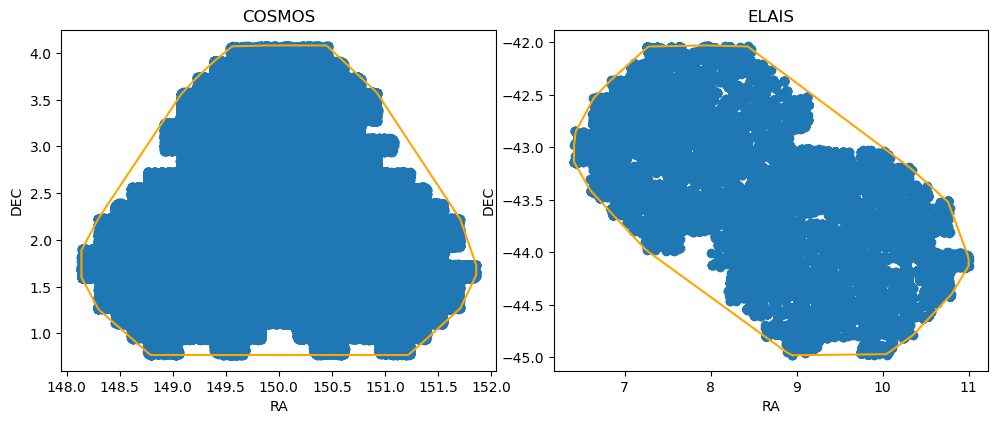

In [13]:
fig, ax = plt.subplots(1,2) 
fig.set_size_inches(10,4)  
fig.tight_layout()

ax[0].set_title("COSMOS")
ax[0].set_xlabel('RA')
ax[0].set_ylabel('DEC')
ax[0].scatter(*radecquery_cosmos)
ax[0].plot(convhullarr_cosmos[0],convhullarr_cosmos[1],color='orange') 

ax[1].set_title("ELAIS")
ax[1].set_xlabel('RA')
ax[1].set_ylabel('DEC')
ax[1].scatter(*radecquery_elais)
ax[1].plot(convhullarr_elais[0],convhullarr_elais[1],color='orange');

## Retrive lists of known AGN in our fields from SIMBAD

SIMBAD: http://simbad.u-strasbg.fr/simbad/sim-tap

Saved the results as {field}\_result.txt in this directory.

### All types of AGN from all catalogs

The `AGN..` means all subtypes of AGN (QSOs, seyferts, etc.).

### COSMOS

In [14]:
print("""
SELECT distinct main_id, ra, dec, otype_txt 
FROM basic 
WHERE otype = 'AGN..' 
AND CONTAINS(POINT('ICRS', ra, dec), POLYGON('ICRS', {})) = 1
GROUP BY main_id, otype_txt, ra, dec""".format(str(list(np.array(convhullarr_cosmos).T.flatten()))[1:-1]))


SELECT distinct main_id, ra, dec, otype_txt 
FROM basic 
WHERE otype = 'AGN..' 
AND CONTAINS(POINT('ICRS', ra, dec), POLYGON('ICRS', 148.8, 0.77, 148.78, 0.78, 148.45, 1.11, 148.3, 1.26, 148.29, 1.28, 148.14, 1.6, 148.14, 1.89, 148.3, 2.23, 149.08, 3.56, 149.23, 3.74, 149.39, 3.91, 149.56, 4.07, 149.88, 4.08, 150.44, 4.08, 150.46, 4.07, 150.92, 3.58, 151.71, 2.22, 151.86, 1.73, 151.86, 1.63, 151.85, 1.6, 151.71, 1.27, 151.39, 0.94, 151.22, 0.77, 148.8, 0.77)) = 1
GROUP BY main_id, otype_txt, ra, dec


### ELAIS

In [16]:
print("""
SELECT distinct main_id, ra, dec, otype_txt 
FROM basic 
WHERE otype = 'AGN..' 
AND CONTAINS(POINT('ICRS', ra, dec), POLYGON('ICRS', {})) = 1 
GROUP BY main_id, otype_txt, ra, dec""".format(str(list(np.array(convhullarr_elais).T.flatten()))[1:-1]))


SELECT distinct main_id, ra, dec, otype_txt 
FROM basic 
WHERE otype = 'AGN..' 
AND CONTAINS(POINT('ICRS', ra, dec), POLYGON('ICRS', 8.95, -44.98, 8.88, -44.95, 7.25, -43.98, 6.86, -43.64, 6.6, -43.41, 6.41, -43.14, 6.41, -42.98, 6.43, -42.85, 6.64, -42.53, 6.84, -42.36, 7.26, -42.05, 7.28, -42.04, 7.94, -42.03, 7.97, -42.03, 8.43, -42.04, 10.31, -43.19, 10.34, -43.21, 10.76, -43.52, 10.99, -44.03, 11.0, -44.07, 11.0, -44.13, 10.8, -44.4, 10.35, -44.79, 10.06, -44.96, 10.04, -44.97, 8.95, -44.98)) = 1 
GROUP BY main_id, otype_txt, ra, dec


### COSMOS field, ACS-GC catalog AGN

In [18]:
print("""
SELECT distinct IDENT.id, basic.ra, basic.dec, basic.otype_txt
FROM basic
JOIN IDENT on IDENT.oidref=basic.oid
WHERE basic.otype = 'AGN..'
AND IDENT.id like 'ACS-GC%'
AND CONTAINS(POINT('ICRS', basic.ra, basic.dec), POLYGON('ICRS', {})) = 1
GROUP BY IDENT.id, basic.otype_txt, basic.ra, basic.dec
""".format(str(list(np.array(convhullarr_cosmos).T.flatten()))[1:-1]))


SELECT distinct IDENT.id, basic.ra, basic.dec, basic.otype_txt
FROM basic
JOIN IDENT on IDENT.oidref=basic.oid
WHERE basic.otype = 'AGN..'
AND IDENT.id like 'ACS-GC%'
AND CONTAINS(POINT('ICRS', basic.ra, basic.dec), POLYGON('ICRS', 148.8, 0.77, 148.78, 0.78, 148.45, 1.11, 148.3, 1.26, 148.29, 1.28, 148.14, 1.6, 148.14, 1.89, 148.3, 2.23, 149.08, 3.56, 149.23, 3.74, 149.39, 3.91, 149.56, 4.07, 149.88, 4.08, 150.44, 4.08, 150.46, 4.07, 150.92, 3.58, 151.71, 2.22, 151.86, 1.73, 151.86, 1.63, 151.85, 1.6, 151.71, 1.27, 151.39, 0.94, 151.22, 0.77, 148.8, 0.77)) = 1
GROUP BY IDENT.id, basic.otype_txt, basic.ra, basic.dec



### COSMOS field, COSMOS2015 catalog AGN

In [20]:
print("""
SELECT distinct IDENT.id, basic.ra, basic.dec, basic.otype_txt
FROM basic
JOIN IDENT on IDENT.oidref=basic.oid
WHERE basic.otype = 'AGN..'
AND IDENT.id like 'COSMOS2015%'
AND CONTAINS(POINT('ICRS', basic.ra, basic.dec), POLYGON('ICRS', {})) = 1
GROUP BY IDENT.id, basic.otype_txt, basic.ra, basic.dec
""".format(str(list(np.array(convhullarr_cosmos).T.flatten()))[1:-1]))


SELECT distinct IDENT.id, basic.ra, basic.dec, basic.otype_txt
FROM basic
JOIN IDENT on IDENT.oidref=basic.oid
WHERE basic.otype = 'AGN..'
AND IDENT.id like 'COSMOS2015%'
AND CONTAINS(POINT('ICRS', basic.ra, basic.dec), POLYGON('ICRS', 148.8, 0.77, 148.78, 0.78, 148.45, 1.11, 148.3, 1.26, 148.29, 1.28, 148.14, 1.6, 148.14, 1.89, 148.3, 2.23, 149.08, 3.56, 149.23, 3.74, 149.39, 3.91, 149.56, 4.07, 149.88, 4.08, 150.44, 4.08, 150.46, 4.07, 150.92, 3.58, 151.71, 2.22, 151.86, 1.73, 151.86, 1.63, 151.85, 1.6, 151.71, 1.27, 151.39, 0.94, 151.22, 0.77, 148.8, 0.77)) = 1
GROUP BY IDENT.id, basic.otype_txt, basic.ra, basic.dec



### ELAIS field, ESIS catalog AGN

In [22]:
print("""
SELECT distinct IDENT.id, basic.ra, basic.dec, basic.otype_txt
FROM basic
JOIN IDENT on IDENT.oidref=basic.oid
WHERE basic.otype = 'AGN..'
AND IDENT.id like 'ESIS%'
AND CONTAINS(POINT('ICRS', basic.ra, basic.dec), POLYGON('ICRS', {})) = 1
GROUP BY IDENT.id, basic.otype_txt, basic.ra, basic.dec
""".format(str(list(np.array(convhullarr_elais).T.flatten()))[1:-1]))


SELECT distinct IDENT.id, basic.ra, basic.dec, basic.otype_txt
FROM basic
JOIN IDENT on IDENT.oidref=basic.oid
WHERE basic.otype = 'AGN..'
AND IDENT.id like 'ESIS%'
AND CONTAINS(POINT('ICRS', basic.ra, basic.dec), POLYGON('ICRS', 8.95, -44.98, 8.88, -44.95, 7.25, -43.98, 6.86, -43.64, 6.6, -43.41, 6.41, -43.14, 6.41, -42.98, 6.43, -42.85, 6.64, -42.53, 6.84, -42.36, 7.26, -42.05, 7.28, -42.04, 7.94, -42.03, 7.97, -42.03, 8.43, -42.04, 10.31, -43.19, 10.34, -43.21, 10.76, -43.52, 10.99, -44.03, 11.0, -44.07, 11.0, -44.13, 10.8, -44.4, 10.35, -44.79, 10.06, -44.96, 10.04, -44.97, 8.95, -44.98)) = 1
GROUP BY IDENT.id, basic.otype_txt, basic.ra, basic.dec



### ELAIS field, SWIRE catalog AGN

In [23]:
print("""
SELECT distinct IDENT.id, basic.ra, basic.dec, basic.otype_txt
FROM basic
JOIN IDENT on IDENT.oidref=basic.oid
WHERE basic.otype = 'AGN..'
AND IDENT.id like 'SWIRE%'
AND CONTAINS(POINT('ICRS', basic.ra, basic.dec), POLYGON('ICRS', {})) = 1
GROUP BY IDENT.id, basic.otype_txt, basic.ra, basic.dec
""".format(str(list(np.array(convhullarr_elais).T.flatten()))[1:-1]))


SELECT distinct IDENT.id, basic.ra, basic.dec, basic.otype_txt
FROM basic
JOIN IDENT on IDENT.oidref=basic.oid
WHERE basic.otype = 'AGN..'
AND IDENT.id like 'SWIRE%'
AND CONTAINS(POINT('ICRS', basic.ra, basic.dec), POLYGON('ICRS', 8.95, -44.98, 8.88, -44.95, 7.25, -43.98, 6.86, -43.64, 6.6, -43.41, 6.41, -43.14, 6.41, -42.98, 6.43, -42.85, 6.64, -42.53, 6.84, -42.36, 7.26, -42.05, 7.28, -42.04, 7.94, -42.03, 7.97, -42.03, 8.43, -42.04, 10.31, -43.19, 10.34, -43.21, 10.76, -43.52, 10.99, -44.03, 11.0, -44.07, 11.0, -44.13, 10.8, -44.4, 10.35, -44.79, 10.06, -44.96, 10.04, -44.97, 8.95, -44.98)) = 1
GROUP BY IDENT.id, basic.otype_txt, basic.ra, basic.dec



### Read in the query results

Define ID, RA, Dec, and type of AGN, as numpy arrays, in each catalog.

In [69]:
fnm = './all_agn_catalog_results/COSMOS_result.txt'
cosmos_id = np.loadtxt(fnm, skiprows=2, delimiter='|', usecols={0}, dtype='str')
cosmos_ra = np.loadtxt(fnm, skiprows=2, delimiter='|', usecols={1}, dtype='float')
cosmos_dec = np.loadtxt(fnm, skiprows=2, delimiter='|', usecols={2}, dtype='float')
cosmos_type = np.loadtxt(fnm, skiprows=2, delimiter='|', usecols={3}, dtype='str')
cosmos_coords = np.array([cosmos_ra, cosmos_dec]).T

fnm = './all_agn_catalog_results/COSMOS2015_result.txt'
cosmos15_id = np.loadtxt(fnm, skiprows=2, delimiter='|', usecols={0}, dtype='str')
cosmos15_ra = np.loadtxt(fnm, skiprows=2, delimiter='|', usecols={1}, dtype='float')
cosmos15_dec = np.loadtxt(fnm, skiprows=2, delimiter='|', usecols={2}, dtype='float')
cosmos15_type = np.loadtxt(fnm, skiprows=2, delimiter='|', usecols={3}, dtype='str')
cosmos15_coords = np.array([cosmos15_ra, cosmos15_dec]).T

fnm = './all_agn_catalog_results/ACS-GC_result.txt'
acs_id = np.loadtxt(fnm, skiprows=2, delimiter='|', usecols={0}, dtype='str')
acs_ra = np.loadtxt(fnm, skiprows=2, delimiter='|', usecols={1}, dtype='float')
acs_dec = np.loadtxt(fnm, skiprows=2, delimiter='|', usecols={2}, dtype='float')
acs_type = np.loadtxt(fnm, skiprows=2, delimiter='|', usecols={3}, dtype='str')
acs_coords = np.array([acs_ra, acs_dec]).T

fnm = './all_agn_catalog_results/ELAIS_result.txt'
elais_id = np.loadtxt(fnm, skiprows=2, delimiter='|', usecols={0}, dtype='str')
elais_ra = np.loadtxt(fnm, skiprows=2, delimiter='|', usecols={1}, dtype='float')
elais_dec = np.loadtxt(fnm, skiprows=2, delimiter='|', usecols={2}, dtype='float')
elais_type = np.loadtxt(fnm, skiprows=2, delimiter='|', usecols={3}, dtype='str')
elais_coords = np.array([elais_ra, elais_dec]).T

fnm = './all_agn_catalog_results/ESIS_result.txt'
esis_id = np.loadtxt(fnm, skiprows=2, delimiter='|', usecols={0}, dtype='str')
esis_ra = np.loadtxt(fnm, skiprows=2, delimiter='|', usecols={1}, dtype='float')
esis_dec = np.loadtxt(fnm, skiprows=2, delimiter='|', usecols={2}, dtype='float')
esis_type = np.loadtxt(fnm, skiprows=2, delimiter='|', usecols={3}, dtype='str')
esis_coords = np.array([esis_ra, esis_dec]).T

fnm = './all_agn_catalog_results/SWIRE_result.txt'
swire_id = np.loadtxt(fnm, skiprows=2, delimiter='|', usecols={0}, dtype='str')
swire_ra = np.loadtxt(fnm, skiprows=2, delimiter='|', usecols={1}, dtype='float')
swire_dec = np.loadtxt(fnm, skiprows=2, delimiter='|', usecols={2}, dtype='float')
swire_type = np.loadtxt(fnm, skiprows=2, delimiter='|', usecols={3}, dtype='str')
swire_coords = np.array([swire_ra, swire_dec]).T

Example of the coords array:

In [38]:
esis_coords[:5]

array([[  8.45583333, -43.38527778],
       [  8.35625   , -43.36916667],
       [  8.47333333, -43.35777778],
       [  8.29208333, -43.35138889],
       [  8.46208333, -43.35222222]])

Example lengths of arrays:

In [39]:
print('COSMOS, all:      ', len(cosmos_id))
print('COSMOS, COSMOS15: ', len(cosmos15_id))
print('COSMOS, ACS-GC:   ', len(acs_id))
print(' ')
print('ELIAS, all:   ', len(elais_id))
print('ELIAS, ESIS:  ', len(esis_id))
print('ELIAS, SWIRE: ', len(swire_id))

COSMOS, all:       6520
COSMOS, COSMOS15:  3696
COSMOS, ACS-GC:    2692
 
ELIAS, all:    527
ELIAS, ESIS:   347
ELIAS, SWIRE:  209


## Draw a tighter polygon around our fields

Create a stricter boundary by making a grid and labelling each rectangle as 'containing data' or not.

If the data are not condensed like this, making the polygon gets computationally prohibitive.

The `prec=0.05` sets the polygon parameter (grid spacing).

In [40]:
prec=0.05

Plot the COSMOS and ELAIS objects in blue, and the grid that will be used to make the polygons in black.

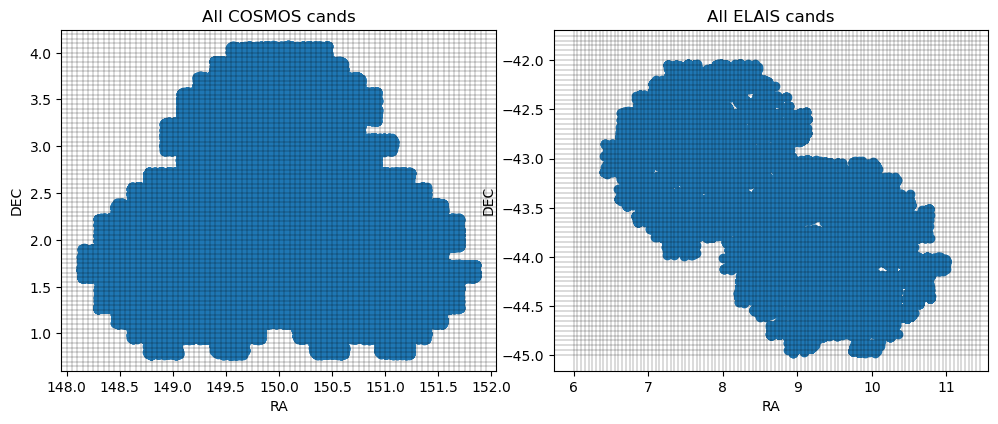

In [41]:
fig, ax = plt.subplots(1, 2) 
fig.set_size_inches(10, 4)  
fig.tight_layout()

ax[0].set_title("All COSMOS cands")
ax[0].set_xlabel('RA')
ax[0].set_ylabel('DEC')
ax[0].scatter(*radecquery_cosmos)
ys_cosmos = np.arange(0.65, 4.25, prec)
xs_cosmos = np.arange(148, 152, prec)
xys_cosmos = np.meshgrid(xs_cosmos, ys_cosmos)

ax[1].set_title("All ELAIS cands")
ax[1].set_xlabel('RA')
ax[1].set_ylabel('DEC')
ax[1].scatter(*radecquery_elais)
ys_elais = np.arange(-45.0, -41.7, prec)
xs_elais = np.arange(6, 11.5, prec)
xys_elais = np.meshgrid(xs_elais, ys_elais)

for i in ys_cosmos:
    ax[0].axhline(i, color='black',lw=0.2)
for i in xs_cosmos:
    ax[0].axvline(i, color='black',lw=0.2)
for i in ys_elais:
    ax[1].axhline(i, color='black',lw=0.2)
for i in xs_elais:
    ax[1].axvline(i, color='black',lw=0.2)

### Identify grid boxes populated by objects

For the COSMOS and the ELAIS fields.

Use `goodxs_cosmos = xs_cosmos[goodidx_cosmos[0]] + prec/2` to get the center coordinate within the grid box.

In [42]:
good_cosmos = []
for i in range(len(xs_cosmos)):
    for j in range(len(ys_cosmos)):
        data = radecquery_cosmos[0][np.where((radecquery_cosmos[0]<xs_cosmos[i]+prec) \
                                             & (radecquery_cosmos[0]>xs_cosmos[i]) \
                                             & (radecquery_cosmos[1]<ys_cosmos[j]+prec) \
                                             & (radecquery_cosmos[1]>ys_cosmos[j]))[0]]
        if len(data) > 0:
            good_cosmos.append([i,j])
goodidx_cosmos = np.array(good_cosmos).transpose()
goodxs_cosmos = xs_cosmos[goodidx_cosmos[0]] + prec/2
goodys_cosmos = ys_cosmos[goodidx_cosmos[1]] + prec/2
goods_cosmos = np.array([goodxs_cosmos,goodys_cosmos])

good_elais = []
for i in range(len(xs_elais)):
    for j in range(len(ys_elais)):
        data = radecquery_elais[0][np.where((radecquery_elais[0]<xs_elais[i]+prec) \
                                            & (radecquery_elais[0]>xs_elais[i]) \
                                            & (radecquery_elais[1]<ys_elais[j]+prec) \
                                            & (radecquery_elais[1]>ys_elais[j]))[0]]
        if len(data) > 0:
            good_elais.append([i,j])
goodidx_elais = np.array(good_elais).transpose()
goodxs_elais = xs_elais[goodidx_elais[0]] + prec/2
goodys_elais = ys_elais[goodidx_elais[1]] + prec/2
goods_elais = np.array([goodxs_elais,goodys_elais])

Show the grid boxes populated by objects as orange.

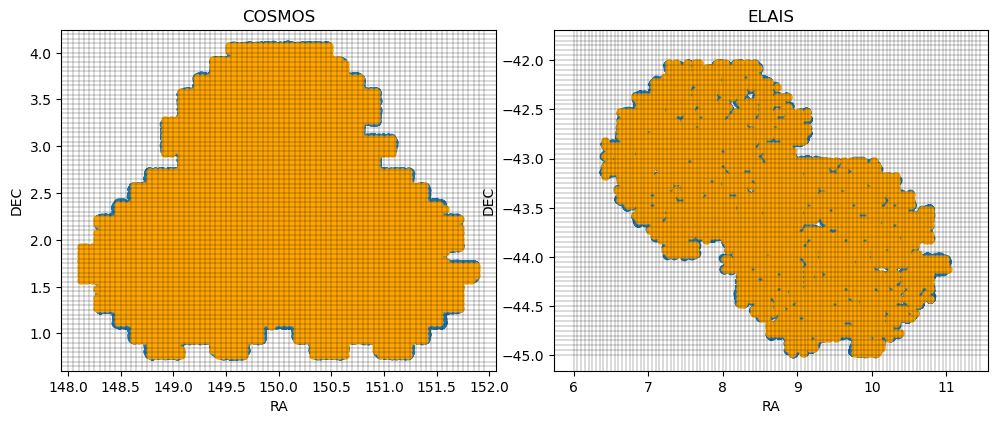

In [43]:
fig, ax = plt.subplots(1,2) 
fig.set_size_inches(10,4)  
fig.tight_layout()

ax[0].set_title("COSMOS")
ax[0].set_xlabel('RA')
ax[0].set_ylabel('DEC')
ax[0].scatter(*radecquery_cosmos)
ax[0].scatter(*goods_cosmos,lw=0.05, color='orange')

for i in ys_cosmos:
    ax[0].axhline(i, color='black',lw=0.2)
for i in xs_cosmos:
    ax[0].axvline(i, color='black',lw=0.2)
    
ax[1].set_title("ELAIS")
ax[1].set_xlabel('RA')
ax[1].set_ylabel('DEC')
ax[1].scatter(*radecquery_elais)
ax[1].scatter(*goods_elais,lw=0.05, color='orange')

for i in ys_elais:
    ax[1].axhline(i, color='black',lw=0.2)
for i in xs_elais:
    ax[1].axvline(i, color='black',lw=0.2)

### Create the new bounding polygons.

In [44]:
pol2str_cosmos = str([str(i[0])+" "+str(i[1]) for i in np.round(goods_cosmos.T,2)]).replace("'","")
pol2_cosmos = wkt.loads("POLYGON (({}))".format(pol2str_cosmos[1:-1]+', '+pol2str_cosmos[1:12])) # COSMOS

pol2str_elais = str([str(i[0])+" "+str(i[1]) for i in np.round(goods_elais.T,2)]).replace("'","")
pol2_elais = wkt.loads("POLYGON (({}))".format(pol2str_elais[1:-1]+', '+pol2str_elais[1:12])) # ELAIS

pol3_cosmos = pol2_cosmos.buffer(prec)
pol3_elais = pol2_elais.buffer(prec)
pol3arr_cosmos = pol3_cosmos.exterior.coords.xy
pol3arr_elais = pol3_elais.exterior.coords.xy

## Identify known AGN within/outside our bounding polygons

In [45]:
%%time
cosmos_msk = []
for coord in cosmos_coords:
    pt = Point(coord[0],coord[1])
    cosmos_msk.append(pt.within(pol3_cosmos))
cosmos_coords1 = cosmos_coords[cosmos_msk]
cosmos_id1 = cosmos_id[cosmos_msk]
cosmos_type1 = cosmos_type[cosmos_msk]

cosmos15_msk = []
for coord in cosmos15_coords:
    pt = Point(coord[0],coord[1])
    cosmos15_msk.append(pt.within(pol3_cosmos))
cosmos15_coords1 = cosmos15_coords[cosmos15_msk]
cosmos15_id1 = cosmos15_id[cosmos15_msk]
cosmos15_type1 = cosmos15_type[cosmos15_msk]

acs_msk = []
for coord in acs_coords:
    pt = Point(coord[0],coord[1])
    acs_msk.append(pt.within(pol3_cosmos))
acs_coords1 = acs_coords[acs_msk]
acs_id1 = acs_id[acs_msk]
acs_type1 = acs_type[acs_msk]

CPU times: user 1.89 s, sys: 199 µs, total: 1.89 s
Wall time: 1.88 s


In [46]:
%%time
elais_msk = []
for coord in elais_coords:
    pt = Point(coord[0],coord[1])
    elais_msk.append(pt.within(pol3_elais))
elais_coords1 = elais_coords[elais_msk]
elais_id1 = elais_id[elais_msk]
elais_type1 = elais_type[elais_msk]

esis_msk = []
for coord in esis_coords:
    pt = Point(coord[0],coord[1])
    esis_msk.append(pt.within(pol3_elais))
esis_coords1 = esis_coords[esis_msk]
esis_id1 = esis_id[esis_msk]
esis_type1 = esis_type[esis_msk]

swire_msk = []
for coord in swire_coords:
    pt = Point(coord[0],coord[1])
    swire_msk.append(pt.within(pol3_elais))
swire_coords1 = swire_coords[swire_msk]
swire_id1 = swire_id[swire_msk]
swire_type1 = swire_type[swire_msk]

CPU times: user 192 ms, sys: 3.3 ms, total: 195 ms
Wall time: 194 ms


For example, print the number from each catalog that are within the boundaries.

In [47]:
print('COSMOS, all:      ', len(cosmos_id), len(cosmos_id1))
print('COSMOS, COSMOS15: ', len(cosmos15_id), len(cosmos15_id1))
print('COSMOS, ACS-GC:   ', len(acs_id), len(acs_id1))
print(' ')
print('ELIAS, all:   ', len(elais_id), len(elais_id1))
print('ELIAS, ESIS:  ', len(esis_id), len(esis_id1))
print('ELIAS, SWIRE: ', len(swire_id), len(swire_id1))

COSMOS, all:       6520 6484
COSMOS, COSMOS15:  3696 3696
COSMOS, ACS-GC:    2692 2692
 
ELIAS, all:    527 520
ELIAS, ESIS:   347 347
ELIAS, SWIRE:  209 207


### Visualize the known AGN within and outside the boundaries

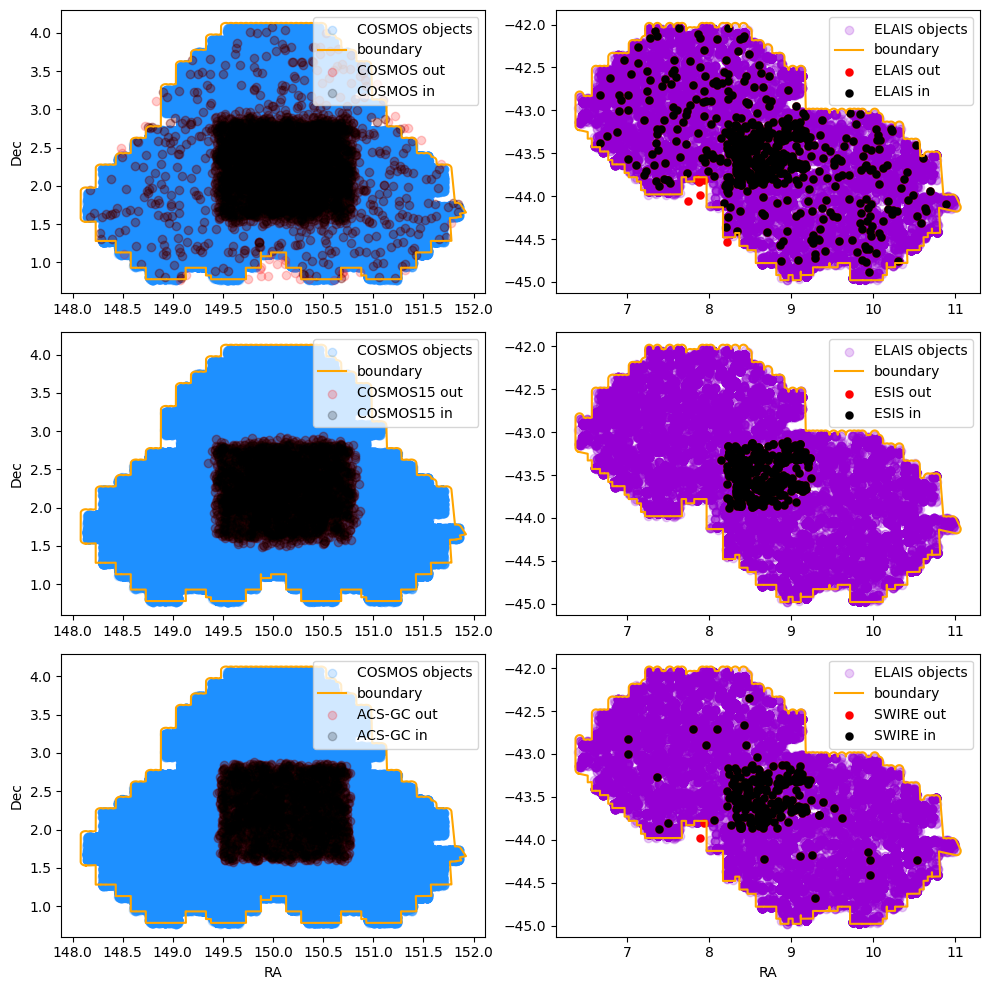

In [48]:
fig, ax = plt.subplots(3, 2) 
fig.set_size_inches(10, 10) 
fig.patch.set_facecolor('white')

ax[0,0].scatter(*radecquery_cosmos, color='dodgerblue', alpha=0.2, label='COSMOS objects')
ax[0,0].plot(*pol3arr_cosmos, color='orange', label='boundary')
ax[0,0].scatter(*cosmos_coords.T, color='red', alpha=0.2, label="COSMOS out")
ax[0,0].scatter(*cosmos_coords1.T, color='black', alpha=0.2, label="COSMOS in")
ax[0,0].legend(loc='upper right')

ax[1,0].scatter(*radecquery_cosmos, color='dodgerblue', alpha=0.2, label='COSMOS objects')
ax[1,0].plot(*pol3arr_cosmos, color='orange',label='boundary')
ax[1,0].scatter(*cosmos15_coords.T, color='red', alpha=0.2, label="COSMOS15 out")
ax[1,0].scatter(*cosmos15_coords1.T, color='black', alpha=0.2, label="COSMOS15 in")
ax[1,0].legend(loc='upper right')

ax[2,0].scatter(*radecquery_cosmos, color='dodgerblue', alpha=0.2, label='COSMOS objects')
ax[2,0].plot(*pol3arr_cosmos, color='orange',label='boundary')
ax[2,0].scatter(*acs_coords.T, color='red',alpha=0.2, label='ACS-GC out')
ax[2,0].scatter(*acs_coords1.T, color='black', alpha=0.2, label='ACS-GC in')
ax[2,0].legend(loc='upper right')

ax[0,1].scatter(*radecquery_elais, color='darkviolet', alpha=0.2, label='ELAIS objects')
ax[0,1].plot(*pol3arr_elais, color='orange', label='boundary')
ax[0,1].scatter(*elais_coords.T, color='red', lw=0.1, label='ELAIS out')
ax[0,1].scatter(*elais_coords1.T, color='black', lw=0.1, label='ELAIS in')
ax[0,1].legend(loc='upper right')

ax[1,1].scatter(*radecquery_elais, color='darkviolet', alpha=0.2, label='ELAIS objects')
ax[1,1].plot(*pol3arr_elais, color='orange', label='boundary')
ax[1,1].scatter(*esis_coords.T, color='red', lw=0.1, label='ESIS out')
ax[1,1].scatter(*esis_coords1.T, color='black', lw=0.1, label='ESIS in')
ax[1,1].legend(loc='upper right')

ax[2,1].scatter(*radecquery_elais, color='darkviolet', alpha=0.2, label='ELAIS objects')
ax[2,1].plot(*pol3arr_elais, color='orange', label='boundary')
ax[2,1].scatter(*swire_coords.T, color='red', lw=0.1, label='SWIRE out')
ax[2,1].scatter(*swire_coords1.T, color='black', lw=0.1, label='SWIRE in')
ax[2,1].legend(loc='upper right')

ax[0,0].set_ylabel("Dec")
ax[1,0].set_ylabel("Dec")
ax[2,0].set_ylabel("Dec")
ax[2,0].set_xlabel("RA")
ax[2,1].set_xlabel("RA")

fig.tight_layout()
fig.savefig("fig_match.png", transparent=False);

## Match to the 2022 sample of "probably-real" candidates

Read in the 'probably-real' candidates that were identified for the paper.

In [85]:
filename = '../../extragalactic_fields/candidate_nightly_epochs_files/candidate_lightcurve_parameters.dat'
realcandsarr = np.genfromtxt(filename, dtype=str)
realcands = np.unique(realcandsarr.T[1])

In [86]:
realcands

array(['DC21baaa', 'DC21baab', 'DC21babt', ..., 'DC22eclvq', 'DC22edblt',
       'DC22engvv'], dtype='<U9')

Retrieve the coordinates for these candidates. Convert to `SkyCoord` format.

In [87]:
%%time
candcoord = []
for i in realcands:
    query = ("SELECT c.ra, c.dec FROM candidates c "
             "WHERE c.id = %s "
             "LIMIT 1")
    cursor.execute(query, (i,))
    res = np.array(cursor.fetchall())[0]
    candcoord.append([i, res])
candcoord1 = np.array([[i[0], SkyCoord(i[1][0], i[1][1], unit='deg')] for i in candcoord])

CPU times: user 1.98 s, sys: 58.6 ms, total: 2.04 s
Wall time: 4.39 s


Check that the `realcands` and `candcoord1` arrays have the same size.

In [88]:
print(len(realcands), len(candcoord1))

4383 4383


Convert the coordinates of the known AGN from SIMBAD into `SkyCoord` format.

In [89]:
%%time
cosmos_coords2 = SkyCoord(cosmos_coords1, unit='deg')
cosmos15_coords2 = SkyCoord(cosmos15_coords1, unit='deg')
acs_coords2 = SkyCoord(acs_coords1, unit='deg')

elais_coords2 = SkyCoord(elais_coords1, unit='deg')
esis_coords2 = SkyCoord(esis_coords1, unit='deg')
swire_coords2 = SkyCoord(swire_coords1, unit='deg')

CPU times: user 0 ns, sys: 7.39 ms, total: 7.39 ms
Wall time: 6.14 ms


Match the datasets with a 2 arcsec radius.

In [90]:
%%time

cosmos_matches = []
cosmos_allseps = []
for i, coord in enumerate(candcoord1.T[1]):
    idx, sep2d, dist3d = coord.match_to_catalog_sky(cosmos_coords2)
    cosmos_allseps.append(sep2d*3600.0)
    if sep2d < 2*u.arcsec:
        cosmos_matches.append([i, coord, idx, sep2d])
cosmos_matches = np.array(cosmos_matches, dtype='object')

cosmos15_matches = []
cosmos15_allseps = []
for i, coord in enumerate(candcoord1.T[1]):
    idx, sep2d, dist3d = coord.match_to_catalog_sky(cosmos15_coords2)
    cosmos15_allseps.append(sep2d*3600.0)
    if sep2d < 2*u.arcsec:
        cosmos15_matches.append([i, coord, idx, sep2d])
cosmos15_matches = np.array(cosmos15_matches, dtype='object')

acs_matches = []
acs_allseps = []
for i, coord in enumerate(candcoord1.T[1]):
    idx, sep2d, dist3d = coord.match_to_catalog_sky(acs_coords2)
    acs_allseps.append(sep2d*3600.0)
    if sep2d < 2*u.arcsec:
        acs_matches.append([i, coord, idx, sep2d])
acs_matches = np.array(acs_matches, dtype='object')

elais_matches = []
elais_allseps = []
for i, coord in enumerate(candcoord1.T[1]):
    idx, sep2d, dist3d = coord.match_to_catalog_sky(elais_coords2)
    elais_allseps.append(sep2d*3600.0)
    if sep2d < 2*u.arcsec:
        elais_matches.append([i, coord, idx, sep2d])
elais_matches = np.array(elais_matches, dtype='object')

esis_matches = []
esis_allseps = []
for i, coord in enumerate(candcoord1.T[1]):
    idx, sep2d, dist3d = coord.match_to_catalog_sky(esis_coords2)
    esis_allseps.append(sep2d*3600.0)
    if sep2d < 2*u.arcsec:
        esis_matches.append([i, coord, idx, sep2d])
esis_matches = np.array(esis_matches, dtype='object')

swire_matches = []
swire_allseps = []
for i, coord in enumerate(candcoord1.T[1]):
    idx, sep2d, dist3d = coord.match_to_catalog_sky(swire_coords2)
    swire_allseps.append(sep2d*3600.0)
    if sep2d < 2*u.arcsec:
        swire_matches.append([i, coord, idx, sep2d])
swire_matches = np.array(swire_matches, dtype='object')

CPU times: user 36.5 s, sys: 171 ms, total: 36.7 s
Wall time: 36.8 s


In [91]:
cosmos_allseps = np.asarray(cosmos_allseps, dtype='float')
cosmos15_allseps = np.asarray(cosmos15_allseps, dtype='float')
acs_allseps = np.asarray(acs_allseps, dtype='float')
elais_allseps = np.asarray(elais_allseps, dtype='float')
esis_allseps = np.asarray(esis_allseps, dtype='float')
swire_allseps = np.asarray(swire_allseps, dtype='float')

### Visualize the distributions of separations

Looking to show that most of the "small" separations (e.g., <10 arcsec, a potential match) are indicative of a real match (e.g., <2 arcseconds).

They are. That's good.

CPU times: user 436 ms, sys: 8.02 ms, total: 444 ms
Wall time: 438 ms


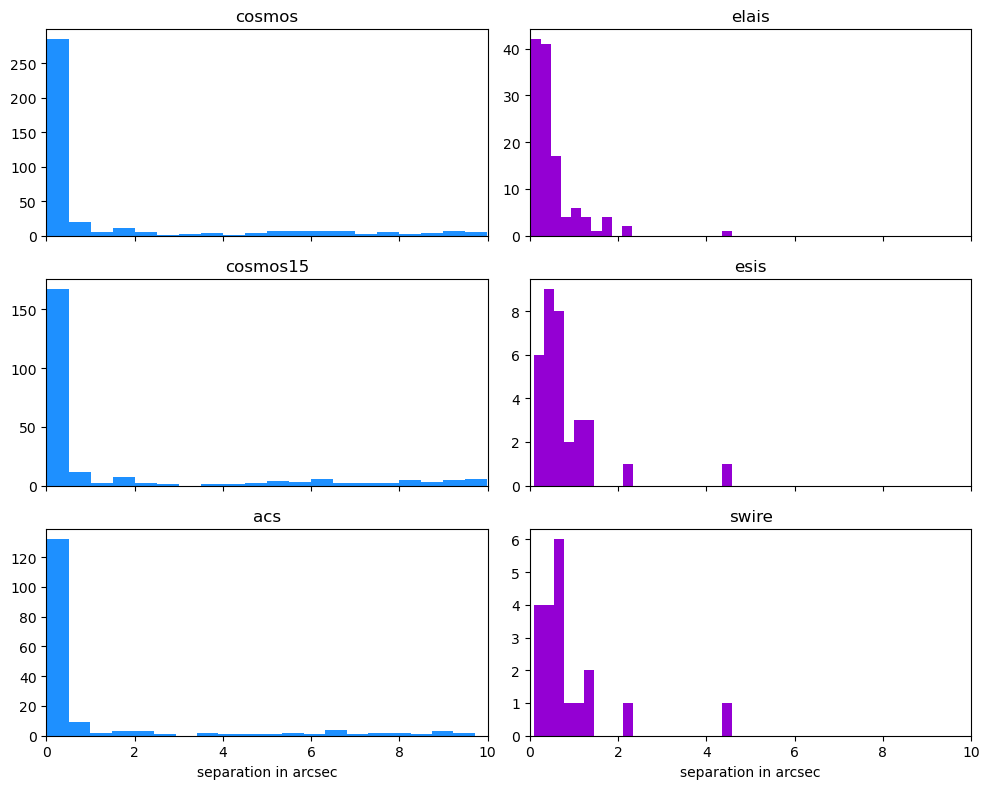

In [92]:
%%time
fig, ax = plt.subplots(3, 2, sharex=True)
fig.set_size_inches(10, 8)

cosmos_tx = np.where(cosmos_allseps < 10.0)[0]
cosmos15_tx = np.where(cosmos15_allseps < 10.0)[0]
acs_tx = np.where(acs_allseps < 10.0)[0]
elais_tx = np.where(elais_allseps < 10.0)[0]
esis_tx = np.where(esis_allseps < 10.0)[0]
swire_tx = np.where(swire_allseps < 10.0)[0]

ax[0,0].hist(cosmos_allseps[cosmos_tx], bins=20, color='dodgerblue')
ax[1,0].hist(cosmos15_allseps[cosmos15_tx], bins=20, color='dodgerblue')
ax[2,0].hist(acs_allseps[acs_tx], bins=20, color='dodgerblue')
ax[0,1].hist(elais_allseps[elais_tx], bins=20, color='darkviolet')
ax[1,1].hist(esis_allseps[esis_tx], bins=20, color='darkviolet')
ax[2,1].hist(swire_allseps[swire_tx], bins=20, color='darkviolet')

ax[0,0].set_title('cosmos')
ax[1,0].set_title('cosmos15')
ax[2,0].set_title('acs')
ax[0,1].set_title('elais')
ax[1,1].set_title('esis')
ax[2,1].set_title('swire')

ax[0,0].set_xlim([0,10])
ax[2,0].set_xlabel('separation in arcsec')
ax[2,1].set_xlabel('separation in arcsec')

fig.tight_layout()

### Print the percentages of known agn matched to our agn candidates

In [93]:
cosmos_matchmsk = cosmos_matches.T[2].astype(int)
cosmos15_matchmsk = cosmos15_matches.T[2].astype(int)
acs_matchmsk = acs_matches.T[2].astype(int)

cosmos_coordsmatched = cosmos_coords1[cosmos_matchmsk]
cosmos15_coordsmatched = cosmos15_coords1[cosmos15_matchmsk]
acs_coordsmatched = acs_coords1[acs_matchmsk]

cosmos_typesmatched = cosmos_type1[cosmos_matchmsk]
cosmos15_typesmatched = cosmos15_type1[cosmos15_matchmsk]
acs_typesmatched = acs_type1[acs_matchmsk]

cosmos_idmatched = cosmos_id1[cosmos_matchmsk]
cosmos15_idmatched = cosmos15_id1[cosmos15_matchmsk]
acs_idmatched = acs_id1[acs_matchmsk]

print("For the COSMOS field:")

print("\nUsing this file: ./COSMOS_result.txt")
for typee in np.unique(cosmos_type):
    cosmos_msk = np.where(cosmos_typesmatched==typee)[0]
    cosmos_nummatched = len(cosmos_idmatched[cosmos_msk])
    try:
        cosmos_numtot = len(cosmos_id1[cosmos_type1==typee])
        cosmos_perc = np.round(cosmos_nummatched/cosmos_numtot*100,2)
        print("found {} out of {} {} ({} %)".format(cosmos_nummatched, cosmos_numtot,typee,cosmos_perc))
    except:
        pass
print("We detected {} known agn as 'probably-real' candidates, "
      "out of {} known agn".format(len(cosmos_matches), len(cosmos_coords1)))
print("This represents {} % of all the known agn in "
      "our field".format(np.round(len(cosmos_matches)/len(cosmos_coords1)*100,2)))

print("\nUsing this file: ./COSMOS2015_result.txt")
for typee in np.unique(cosmos15_type):
    cosmos15_msk = np.where(cosmos15_typesmatched==typee)[0]
    cosmos15_nummatched = len(cosmos15_idmatched[cosmos15_msk])
    try:
        cosmos15_numtot = len(cosmos15_id1[cosmos15_type1==typee])
        cosmos15_perc = np.round(cosmos15_nummatched/cosmos15_numtot*100,2)
        print("found {} out of {} {} ({} %)".format(cosmos15_nummatched, cosmos15_numtot, 
                                                    typee, cosmos15_perc))
    except:
        pass
print("We detected {} known agn as 'probably-real' candidates, "
      "out of {} known agn".format(len(cosmos15_matches), len(cosmos15_coords1)))
print("This represents {} % of all the known agn in "
      "our field".format(np.round(len(cosmos15_matches)/len(cosmos15_coords1)*100,2)))

print("\nUsing this file: ./ACS-GC_result.txt")
for typee in np.unique(acs_type):
    acs_msk = np.where(acs_typesmatched==typee)[0]
    acs_nummatched = len(acs_idmatched[acs_msk])
    try:
        acs_numtot = len(acs_id1[acs_type1==typee])
        acs_perc = np.round(acs_nummatched/acs_numtot*100,2)
        print("found {} out of {} {} ({} %)".format(acs_nummatched, acs_numtot,typee,acs_perc))
    except:
        pass
print("We detected {} known agn as 'probably-real' candidates, "
      "out of {} known agn".format(len(acs_matches), len(acs_coords1)))
print("This represents {} % of all the known agn in "
      "our field".format(np.round(len(acs_matches)/len(acs_coords1)*100,2)))

For the COSMOS field:

Using this file: ./COSMOS_result.txt
found 108 out of 5434 "AGN"     (1.99 %)
found 0 out of 3 "BLL"     (0.0 %)
found 0 out of 32 "LIN"     (0.0 %)
found 192 out of 582 "QSO"     (32.99 %)
found 14 out of 55 "Sy1"     (25.45 %)
found 1 out of 23 "Sy2"     (4.35 %)
found 0 out of 1 "SyG"     (0.0 %)
found 4 out of 354 "rG"      (1.13 %)
We detected 319 known agn as 'probably-real' candidates, out of 6484 known agn
This represents 4.92 % of all the known agn in our field

Using this file: ./COSMOS2015_result.txt
found 93 out of 3197 "AGN"     (2.91 %)
found 0 out of 1 "BLL"     (0.0 %)
found 0 out of 10 "LIN"     (0.0 %)
found 85 out of 271 "QSO"     (31.37 %)
found 6 out of 22 "Sy1"     (27.27 %)
found 0 out of 4 "Sy2"     (0.0 %)
found 3 out of 191 "rG"      (1.57 %)
We detected 187 known agn as 'probably-real' candidates, out of 3696 known agn
This represents 5.06 % of all the known agn in our field

Using this file: ./ACS-GC_result.txt
found 66 out of 2373 "AG

In [94]:
elais_matchmsk = elais_matches.T[2].astype(int)
esis_matchmsk = esis_matches.T[2].astype(int)
swire_matchmsk = swire_matches.T[2].astype(int)

elais_coordsmatched = elais_coords1[elais_matchmsk]
esis_coordsmatched = esis_coords1[esis_matchmsk]
swire_coordsmatched = swire_coords1[swire_matchmsk]

elais_typesmatched = elais_type1[elais_matchmsk]
esis_typesmatched = esis_type1[esis_matchmsk]
swire_typesmatched = swire_type1[swire_matchmsk]

elais_idmatched = elais_id1[elais_matchmsk]
esis_idmatched = esis_id1[esis_matchmsk]
swire_idmatched = swire_id1[swire_matchmsk]

print("For the ELAIS field:")

print("\nUsing this file: ./ELAIS_result.txt")
for typee in np.unique(elais_type):
    elais_msk = np.where(elais_typesmatched==typee)[0]
    elais_nummatched = len(elais_idmatched[elais_msk])
    try:
        elais_numtot = len(elais_id1[elais_type1==typee])
        elais_perc = np.round(elais_nummatched/elais_numtot*100,2)
        print("found {} out of {} {} ({} %)".format(elais_nummatched, elais_numtot,typee,elais_perc))
        #print(f"found {elais_nummatched} out of {elais_numtot} {typee} ({elais_perc} %)")
    except:
        pass
print("We detected {} known agn as 'probably-real' candidates, "
      "out of {} known agn".format(len(elais_matches), len(elais_coords1)))
print("This represents {} % of all the known agn in "
      "our field".format(np.round(len(elais_matches)/len(elais_coords1)*100,2)))

print("\nUsing this file: ./ESIS_result.txt")
for typee in np.unique(esis_type):
    esis_msk = np.where(esis_typesmatched==typee)[0]
    esis_nummatched = len(esis_idmatched[esis_msk])
    try:
        esis_numtot = len(esis_id1[esis_type1==typee])
        esis_perc = np.round(esis_nummatched/esis_numtot*100,2)
        print("found {} out of {} {} ({} %)".format(esis_nummatched, esis_numtot,typee,esis_perc))
    except:
        pass
print("We detected {} known agn as 'probably-real' candidates, "
      "out of {} known agn".format(len(esis_matches), len(esis_coords1)))
print("This represents {} % of all the known agn in "
      "our field".format(np.round(len(esis_matches)/len(esis_coords1)*100,2)))

print("\nUsing this file: ./SWIRE_result.txt")
for typee in np.unique(swire_type):
    swire_msk = np.where(swire_typesmatched==typee)[0]
    swire_nummatched = len(swire_idmatched[swire_msk])
    try:
        swire_numtot = len(swire_id1[swire_type1==typee])
        swire_perc = np.round(swire_nummatched/swire_numtot*100,2)
        print("found {} out of {} {} ({} %)".format(swire_nummatched, swire_numtot,typee,swire_perc))
    except:
        pass
print("We detected {} known agn as 'probably-real' candidates, "
      "out of {} known agn".format(len(swire_matches), len(swire_coords1)))
print("This represents {} % of all the known agn in "
      "our field".format(np.round(len(swire_matches)/len(swire_coords1)*100,2)))

For the ELAIS field:

Using this file: ./ELAIS_result.txt
found 28 out of 248 "AGN"     (11.29 %)
found 0 out of 7 "LIN"     (0.0 %)
found 89 out of 234 "QSO"     (38.03 %)
found 1 out of 6 "Sy1"     (16.67 %)
found 0 out of 23 "Sy2"     (0.0 %)
found 1 out of 1 "SyG"     (100.0 %)
found 0 out of 1 "rG"      (0.0 %)
We detected 119 known agn as 'probably-real' candidates, out of 520 known agn
This represents 22.88 % of all the known agn in our field

Using this file: ./ESIS_result.txt
found 22 out of 300 "AGN"     (7.33 %)
found 0 out of 3 "LIN"     (0.0 %)
found 9 out of 40 "QSO"     (22.5 %)
found 0 out of 2 "Sy1"     (0.0 %)
found 0 out of 2 "Sy2"     (0.0 %)
We detected 31 known agn as 'probably-real' candidates, out of 347 known agn
This represents 8.93 % of all the known agn in our field

Using this file: ./SWIRE_result.txt
found 13 out of 169 "AGN"     (7.69 %)
found 0 out of 2 "LIN"     (0.0 %)
found 5 out of 23 "QSO"     (21.74 %)
found 0 out of 3 "Sy1"     (0.0 %)
found 0 out

### Output match data to file

Output data: AGN ID, RA, Dec, and type'; matched candidate ID and separation distance.

First define the file names to use for the output.

In [109]:
fnmout_cosmos = './all_agn_matches/COSMOS_matches.txt'
fnmout_cosmos15 = './all_agn_matches/COSMOS2015_matches.txt'
fnmout_acs = './all_agn_matches/ACS-GC_matches.txt'

fnmout_elais = './all_agn_matches/ELAIS_matches.txt'
fnmout_esis = './all_agn_matches/ESIS_matches.txt'
fnmout_swire = './all_agn_matches/SWIRE_matches.txt'

Check the formatting for the matching arrays by printing to screen first.

Print the:
* index in the "realcands" array,
* candidate identifier,
* RA and Dec of the AGN,
* index of the AGN in its, e.g., cosmos_coords2 array,
* name and type of the AGN, and 
* match separation in degrees.

In [110]:
# for match in cosmos_matches:
#     print('%6i %10s %9.5f %7.5f %6i %50s %10s %8.6E' % \
#           (match[0], realcands[match[0]], match[1].ra.deg, match[1].dec.deg, \
#           match[2], cosmos_id1[match[2]], cosmos_type1[match[2]], match[3].deg[0]))

# for match in cosmos15_matches:
#     print('%6i %10s %9.5f %7.5f %6i %20s %10s %8.6E' % \
#           (match[0], realcands[match[0]], match[1].ra.deg, match[1].dec.deg, \
#            match[2], cosmos15_id1[match[2]], cosmos15_type1[match[2]], match[3].deg[0]))
    
# for match in acs_matches:
#     print('%6i %10s %9.5f %7.5f %6i %20s %10s %8.6E' % \
#           (match[0], realcands[match[0]], match[1].ra.deg, match[1].dec.deg, \
#            match[2], acs_id1[match[2]], acs_type1[match[2]], match[3].deg[0]))
    
# for match in elais_matches:
#     print('%6i %10s %7.5f %9.5f %6i %35s %10s %8.6E' % \
#           (match[0], realcands[match[0]], match[1].ra.deg, match[1].dec.deg, \
#            match[2], elais_id1[match[2]], elais_type1[match[2]], match[3].deg[0]))

# for match in esis_matches:
#     print('%6i %10s %7.5f %9.5f %6i %35s %10s %8.6E' % \
#           (match[0], realcands[match[0]], match[1].ra.deg, match[1].dec.deg, \
#            match[2], esis_id1[match[2]], esis_type1[match[2]], match[3].deg[0]))
    
# for match in swire_matches:
#     print('%6i %10s %7.5f %9.5f %6i %35s %10s %8.6E' % \
#           (match[0], realcands[match[0]], match[1].ra.deg, match[1].dec.deg, \
#            match[2], swire_id1[match[2]], swire_type1[match[2]], match[3].deg[0]))

Now print to the files. Deliminate with commas. Can't use spaces b/c the AGN IDs have spaces in the names.

In [111]:
fout = open(fnmout_cosmos, 'w')
for match in cosmos_matches:
    fout.write('%s, %9.5f, %7.5f, %s, %s, %8.6E \n' % \
          (cosmos_id1[match[2]].strip().strip('"'), 
           match[1].ra.deg, match[1].dec.deg, 
           cosmos_type1[match[2]].strip().strip('"'), \
           realcands[match[0]], match[3].deg[0]))
fout.close()

In [112]:
fout = open(fnmout_cosmos15, 'w')
for match in cosmos15_matches:
    fout.write('%s, %9.5f, %7.5f, %s, %s, %8.6E \n' % \
          (cosmos15_id1[match[2]].strip().strip('"'), 
           match[1].ra.deg, match[1].dec.deg, 
           cosmos15_type1[match[2]].strip().strip('"'), \
           realcands[match[0]], match[3].deg[0]))
fout.close()

In [113]:
fout = open(fnmout_acs, 'w')
for match in acs_matches:
    fout.write('%s, %9.5f, %7.5f, %s, %s, %8.6E \n' % \
          (acs_id1[match[2]].strip().strip('"'), 
           match[1].ra.deg, match[1].dec.deg, 
           acs_type1[match[2]].strip().strip('"'), \
           realcands[match[0]], match[3].deg[0]))
fout.close()

In [114]:
fout = open(fnmout_elais, 'w')
for match in elais_matches:
    fout.write('%s, %9.5f, %7.5f, %s, %s, %8.6E \n' % \
          (elais_id1[match[2]].strip().strip('"'), 
           match[1].ra.deg, match[1].dec.deg, 
           elais_type1[match[2]].strip().strip('"'), \
           realcands[match[0]], match[3].deg[0]))
fout.close()

In [115]:
fout = open(fnmout_esis, 'w')
for match in esis_matches:
    fout.write('%s, %9.5f, %7.5f, %s, %s, %8.6E \n' % \
          (esis_id1[match[2]].strip().strip('"'), 
           match[1].ra.deg, match[1].dec.deg, 
           esis_type1[match[2]].strip().strip('"'), \
           realcands[match[0]], match[3].deg[0]))
fout.close()

In [116]:
fout = open(fnmout_swire, 'w')
for match in swire_matches:
    fout.write('%s, %9.5f, %7.5f, %s, %s, %8.6E \n' % \
          (swire_id1[match[2]].strip().strip('"'), 
           match[1].ra.deg, match[1].dec.deg, 
           swire_type1[match[2]].strip().strip('"'), \
           realcands[match[0]], match[3].deg[0]))
fout.close()